# Problem Setup

## 1. Problem Setup

**Objective Function:**

$$
f(x) = -\sin(3x) - x^2 + 0.7x
$$

*This is a noisy, non-convex function to minimize.*

**Domain:**

$$
x \in [-2, 2]
$$

**Goal:**

$$
x^* = \arg\min_{x \in [-2,2]} f(x)
$$


In [1]:
import torch
import gpytorch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
# Set random seed
torch.manual_seed(17)

In [5]:
# Objective Fnction

def f(x):
    return -torch.sin(3 * x) - x**2 + 0.7 * x + torch.normal(0, 0.1, size=x.shape)

In [6]:
# --- Data Generation ---
x = torch.linspace(-2, 2, 100).unsqueeze(-1)  # Shape: (100, 1)
true_f = -np.sin(3 * x.numpy()) - x.numpy()**2 + 0.7 * x.numpy()

In [7]:
# Initial points (3 random points)
n_init = 3
train_x = torch.linspace(-2, 2, n_init).unsqueeze(-1)  # Shape: (3, 1)
train_y = f(train_x)  # Shape: (3,)
X_tensor = x  # Full grid for predictions

In [8]:
# --- Define GP Model ---
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=1)
        )
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

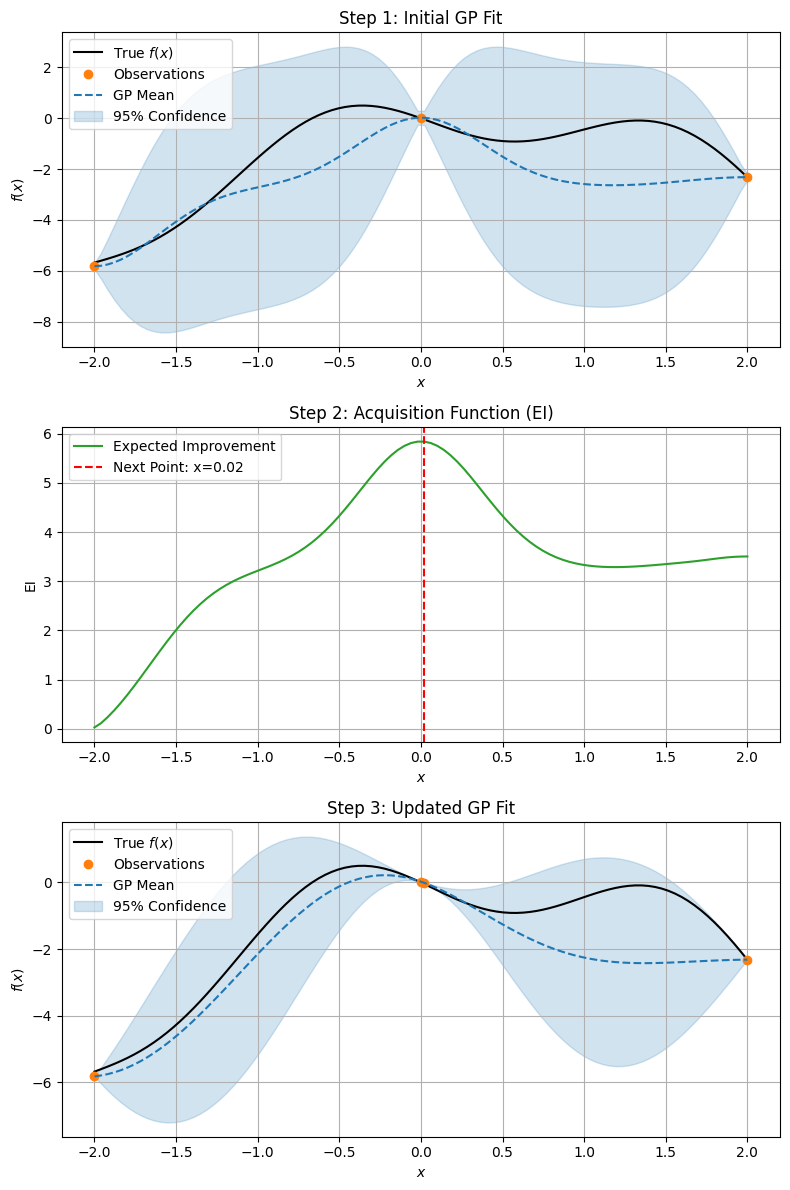

In [10]:
import torch
import gpytorch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Set random seed
torch.manual_seed(17)

# --- Objective Function ---
def f(x):
    return -torch.sin(3 * x) - x**2 + 0.7 * x + torch.normal(0, 0.1, size=x.shape)

# --- Data Generation ---
x = torch.linspace(-2, 2, 100).unsqueeze(-1)  # Shape: (100, 1)
true_f = -np.sin(3 * x.numpy()) - x.numpy()**2 + 0.7 * x.numpy()

# Initial points (3 random points)
n_init = 3
train_x = torch.linspace(-2, 2, n_init).unsqueeze(-1)  # Shape: (3, 1)
train_y = f(train_x).squeeze()  # Shape: (3,), ensure 1D

# --- Define GP Model ---
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=1)
        )
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# --- Training Function ---
def train_model(model, likelihood, train_x, train_y, max_iter=10):
    model.train()
    likelihood.train()
    optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    for _ in range(max_iter):
        def closure():
            optimizer.zero_grad()
            output = model(train_x)
            loss = -mll(output, train_y)  # Should be scalar
            if loss.dim() > 0:  # Ensure scalar output
                loss = loss.sum()  # Reduce to scalar if needed
            loss.backward()
            return loss
        optimizer.step(closure)

# --- Prediction Function ---
def get_predictions(model, likelihood, X_tensor):
    model.eval()
    likelihood.eval()
    with torch.no_grad():
        pred = likelihood(model(X_tensor))
        return pred.mean.numpy(), pred.stddev.numpy()

# --- Expected Improvement Function ---
def expected_improvement(mu, sigma, f_star):
    z = (mu - f_star) / sigma
    ei = (mu - f_star) * norm.cdf(z) + sigma * norm.pdf(z)
    ei[sigma == 0] = 0  # Avoid division by zero
    return ei

# --- BO Steps and Visualization ---
fig, axs = plt.subplots(3, 1, figsize=(8, 12))
X_tensor = x  # Full grid for predictions

# Step 1: Initial GP Fit
likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.Interval(1e-5, 10.0))
model = GPModel(train_x, train_y, likelihood)
model.covar_module.base_kernel.lengthscale = torch.tensor([1.0])
model.covar_module.outputscale = 1.0
likelihood.noise = 0.1
train_model(model, likelihood, train_x, train_y)

mu, sigma = get_predictions(model, likelihood, X_tensor)
ax = axs[0]
ax.plot(x.numpy(), true_f, 'k-', label='True $f(x)$')
ax.plot(train_x.numpy(), train_y.numpy(), 'C1o', label='Observations')
ax.plot(x.numpy(), mu, 'C0--', label='GP Mean')
ax.fill_between(x.numpy().flatten(), mu - 2 * sigma, mu + 2 * sigma, color='C0', alpha=0.2, label='95% Confidence')
ax.set_title('Step 1: Initial GP Fit')
ax.set_xlabel('$x$')
ax.set_ylabel('$f(x)$')
ax.legend(loc='upper left')
ax.grid(True)

# Step 2: Acquisition Function (EI)
f_star = train_y.min().item()
ei = expected_improvement(mu, sigma, f_star)
next_x_idx = np.argmax(ei)
next_x = x[next_x_idx].item()

ax = axs[1]
ax.plot(x.numpy(), ei, 'C2-', label='Expected Improvement')
ax.axvline(next_x, color='r', linestyle='--', label=f'Next Point: x={next_x:.2f}')
ax.set_title('Step 2: Acquisition Function (EI)')
ax.set_xlabel('$x$')
ax.set_ylabel('EI')
ax.legend(loc='upper left')
ax.grid(True)

# Step 3: Updated GP Fit
train_x = torch.cat([train_x, x[next_x_idx].unsqueeze(0)])  # Shape: (4, 1)
train_y = torch.cat([train_y, f(x[next_x_idx].unsqueeze(0)).squeeze().unsqueeze(0)])  # Shape: (4,)
model = GPModel(train_x, train_y, likelihood)
model.covar_module.base_kernel.lengthscale = torch.tensor([1.0])
model.covar_module.outputscale = 1.0
likelihood.noise = 0.1
train_model(model, likelihood, train_x, train_y)

mu, sigma = get_predictions(model, likelihood, X_tensor)
ax = axs[2]
ax.plot(x.numpy(), true_f, 'k-', label='True $f(x)$')
ax.plot(train_x.numpy(), train_y.numpy(), 'C1o', label='Observations')
ax.plot(x.numpy(), mu, 'C0--', label='GP Mean')
ax.fill_between(x.numpy().flatten(), mu - 2 * sigma, mu + 2 * sigma, color='C0', alpha=0.2, label='95% Confidence')
ax.set_title('Step 3: Updated GP Fit')
ax.set_xlabel('$x$')
ax.set_ylabel('$f(x)$')
ax.legend(loc='upper left')
ax.grid(True)

plt.tight_layout()
plt.savefig('bo_1d_visualization.png')
plt.show()

## 2. Gaussian Process (GP) Model

**Prior:**

$$
f(x) \sim \mathcal{GP}(m(x), k(x,x'))
$$

- **Mean Function:**  
  $$
  m(x) = 0
  $$
  *(A constant mean, which can be adjusted during training.)*

- **Covariance Function (Kernel):**  
  Using the RBF (squared exponential) kernel,

  $$
  k(x, x') = \sigma_f^2 \exp\left(-\frac{(x - x')^2}{2l^2}\right)
  $$

  where:
  - \( \sigma_f^2 \) is the output scale,
  - \( l \) is the length scale.

**Observations:**

Each observation is modeled as

$$
y_i = f(x_i) + \epsilon_i, \quad \epsilon_i \sim \mathcal{N}(0, \sigma^2)
$$

**Posterior After \( n \) Observations \( D_n = \{(x_i, y_i)\}_{i=1}^{n} \):**

- **Posterior Mean:**

  $$
  \mu_n(x) = k(x, X_n) \left[K_n + \sigma^2 I\right]^{-1} y_n
  $$

- **Posterior Variance:**

  $$
  \sigma_n^2(x) = k(x,x) - k(x, X_n) \left[K_n + \sigma^2 I\right]^{-1} k(X_n, x)
  $$

where:
- \( K_n = \left[k(x_i, x_j)\right]_{i,j=1}^{n} \) is the kernel matrix,
- \( k(x, X_n) = [k(x, x_1), \ldots, k(x, x_n)] \).

---


## 3. Acquisition Function (Expected Improvement, EI)

**Definition:**

The Expected Improvement (EI) acquisition function is defined as

$$
\alpha_{EI}(x) = \mathbb{E}\left[\max\left(f^* - f(x), 0\right) \mid D_n\right]
$$

with the best observed value

$$
f^* = \min\{y_1, y_2, \dots, y_n\}.
$$

**EI Formula:**

The closed-form expression for EI is

$$
\alpha_{EI}(x) = (\mu_n(x) - f^*) \Phi\left(\frac{\mu_n(x) - f^*}{\sigma_n(x)}\right) + \sigma_n(x) \phi\left(\frac{\mu_n(x) - f^*}{\sigma_n(x)}\right)
$$

where:
- \( \Phi(\cdot) \) is the cumulative distribution function (CDF) of the standard normal distribution,
- \( \phi(\cdot) \) is the probability density function (PDF) of the standard normal distribution.

## 4. Bayesian Optimization Algorithm

1. **Initialization:**  
   Select \( n_0 \) initial points and evaluate the objective function to obtain the initial dataset \( D_{n_0} \).

2. **Gaussian Process Fitting:**  
   Fit the GP model to the current dataset \( D_n \).

3. **Acquisition Optimization:**  
   Maximize the acquisition function to select the next point:

   $$
   x_{n+1} = \arg\max_{x \in [-2, 2]} \alpha_{EI}(x)
   $$

4. **Evaluation and Update:**  
   Evaluate the objective function at the new point \( x_{n+1} \) and update the dataset:

   $$
   D_{n+1} = D_n \cup \{(x_{n+1}, f(x_{n+1}))\}
   $$

5. **Iteration:**  
   Repeat steps 2–4 for a fixed number of iterations or until a convergence criterion is met.